In [1]:
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
import matplotlib.path as mpath

import pandas as pd 

import gsw
%matplotlib inline

In [2]:
# A function that makes xy grid
def make_grid_xy(n, length):
    lx, ly = length, length
    nx, ny = n, n
    dx, dy = lx/nx, ly/ny

    # create mesh-grids for cell centers
    xc, yc = np.meshgrid(
                dx * np.arange(nx) + dx/2,
                dy * np.arange(ny) + dy/2)
    
    return xc, yc

In [3]:
res = 100

Lx = 256e2

n = int(Lx/res)

In [4]:
xc, yc = make_grid_xy(n, Lx)

dx = xc[0,1] - xc[0,0]
dy = yc[1,0] - yc[0,0]
print(dx, dy    , len(xc[0,:]))

100.0 100.0 256


# Bathymetry

In [5]:
Ho = 300

h = -Ho * np.ones((n, n))

# Walls (surrounding domain); generate bathymetry file
#h[:, [0,-1]] = 0   # set ocean depth to zero at east and west walls
h[[0], :] = 0   # set ocean depth to zero at south  wall
# save as single-precision (float32) with big-endian byte ordering
h.astype('>f4').tofile('bathy.bin')

In [6]:
h.shape

(256, 256)

# Wind

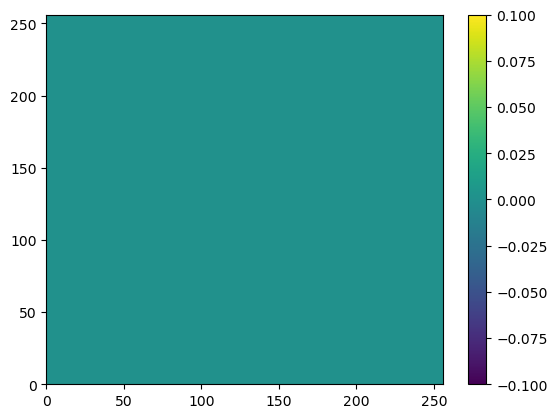

In [7]:
tau0 = 0.0

# make sure that the northern point has zero winds
tau = np.zeros([n,n])


a =10e3 
#L =512e3
tau = tau0*(np.sin(np.pi* (yc-a/2)/(Lx-a))**2) 

tau[yc<=a/2] = 0.
tau[yc>=(Lx-a/2)] = 0.

tau.astype('>f4').tofile('wind.bin')


plt.pcolor(tau)
plt.colorbar()

In [8]:
tau.shape

(256, 256)

(-0.01, 0.15)

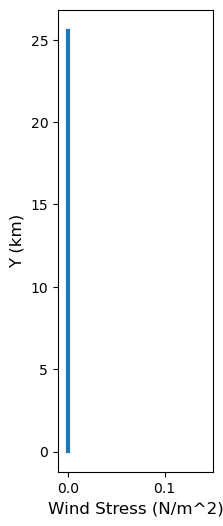

In [9]:
plt.figure(figsize=(2,6))
plt.plot(tau[:,1],yc[:,1]/1000,linewidth=3)
plt.xlabel('Wind Stress (N/m^2)',fontsize='12')
plt.ylabel('Y (km)',fontsize='12')
#plt.ylim([0,256])
plt.xlim([-0.01, 0.15])

# Heat flux

In [10]:
Ho = 0.0

h = Ho * np.ones((n, n))

# Walls (surrounding domain); generate bathymetry file
#h[:, [0,-1]] = 0   # set ocean depth to zero at east and west walls
h[[0], :] = 0   # set ocean depth to zero at south  wall
# save as single-precision (float32) with big-endian byte ordering
h.astype('>f4').tofile('heat_flux.bin')

# Depth levels

In [11]:
delR =   np.array([1.00,    1.14,    1.30,    1.49,   1.70,  
                   1.93,    2.20,    2.50,    2.84,   3.21,        
                   3.63,    4.10,    4.61,    5.18,   5.79,   
                   6.47,    7.20,    7.98,    8.83,   9.73,  
                   10.69,   11.70,   12.76,   13.87,  15.03,   
                   16.22,   17.45,   18.70,   19.97,  21.27,    
                   22.56,   23.87,   25.17,   26.46,  27.74,  
                   29.00,   30.24,   31.45,   32.65,  33.82, 
                   34.97,   36.09,   37.20,   38.29,  39.37,   
                   40.45,   41.53,   42.62,   43.73,  44.87,
                   46.05,   47.28,   48.56,   49.93,  51.38,
                   52.93,   54.61,   56.42,   58.38,  60.53,
                   62.87,   65.43,   68.24,   71.33,  74.73,
                   78.47,   82.61,   87.17,   92.21,  97.79,
                   103.96,  110.79,  118.35,  126.73, 136.01, 174.67])/10

Z = -(delR.cumsum())

In [12]:
delR

array([ 0.1  ,  0.114,  0.13 ,  0.149,  0.17 ,  0.193,  0.22 ,  0.25 ,
        0.284,  0.321,  0.363,  0.41 ,  0.461,  0.518,  0.579,  0.647,
        0.72 ,  0.798,  0.883,  0.973,  1.069,  1.17 ,  1.276,  1.387,
        1.503,  1.622,  1.745,  1.87 ,  1.997,  2.127,  2.256,  2.387,
        2.517,  2.646,  2.774,  2.9  ,  3.024,  3.145,  3.265,  3.382,
        3.497,  3.609,  3.72 ,  3.829,  3.937,  4.045,  4.153,  4.262,
        4.373,  4.487,  4.605,  4.728,  4.856,  4.993,  5.138,  5.293,
        5.461,  5.642,  5.838,  6.053,  6.287,  6.543,  6.824,  7.133,
        7.473,  7.847,  8.261,  8.717,  9.221,  9.779, 10.396, 11.079,
       11.835, 12.673, 13.601, 17.467])

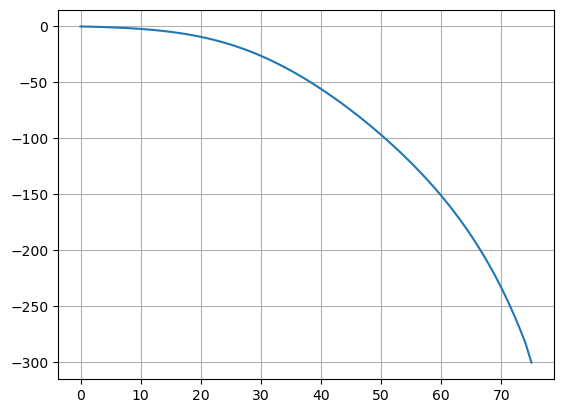

In [13]:
plt.plot(Z)
plt.grid('on')

# 3D Temperature 

In [14]:
## Overly complicated getting initial T profs N and S

nx = n
ny = n
nr = len(delR)
rF = (np.insert(np.cumsum(delR),0,0))
z = np.diff(rF)/2 + rF[:-1]
H = -np.sum(delR) 

Tmax = 12.8 # og 11.5
Tmin = 11.5 # og 8.5
Tmin_int = 8.0

T_surf = np.tile(np.linspace(Tmin, Tmax, n), (n,1)).T
T_surf.astype('>f4').tofile('sst_relax.bin')

h = 12             # e-folding scale for temperature decrease with depth
#T_surf = sst_relax  # use 2-D SST relaxation field for surface values
zscale = (np.exp(-z/h) - np.exp(H/h)) / (1 - np.exp(H/h))
#ztop = np.ones((18,))
#zscale = np.concatenate((ztop,zscale))
zscale = np.reshape(zscale[0:nr], [nr,1,1])
T_3D = np.reshape(T_surf - Tmin_int, [1,ny,nx]) * zscale + Tmin_int

T_3D[-1:-5,:,:] = Tmin_int

In [15]:
#tau0 = 128

# make sure that the northern point has zero winds
y = np.zeros([n,])
x = np.arange(0, n, 1)
y = 4.9*np.sin(2*np.pi*(x)/n)
y_F = np.ceil(y)

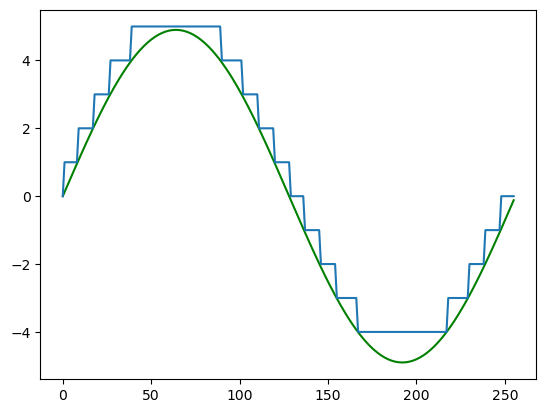

In [16]:
plt.plot(x, y, color='green')
plt.plot(x,y_F)

In [17]:
T_front = np.ones((nr,n,n))

T_S = T_3D[:,1,:]
T_N = T_3D[:,-1,:]

#y_F = 128
for y in np.arange(0,n,1):
    A = ((T_N-T_S))*((np.tanh(((y-(y_F+(n/2)))/25))+1)/2)+T_S

    B1 = ((T_N-T_S))/2*((np.tanh(((y-(y_F+(1.2*n/3)))/12.5))+1)/2)+T_S
    B2 = ((T_N-T_S))/2*((np.tanh(((y-(y_F+(3*n/5)))/12.5))+1)/2)
    
    C1 = ((T_N-T_S))/3*((np.tanh(((y-(y_F+(3.6*n/10)))/7))+1)/2)+T_S
    C2 = ((T_N-T_S))/3*((np.tanh(((y-(y_F+(n/2)))/7))+1)/2)
    C3 = ((T_N-T_S))/3*((np.tanh(((y-(y_F+(6.3*n/10)))/7))+1)/2)
    
    #D1 = ((T_N-T_S))/4*((np.tanh(((y-(y_F+(5.2*n/15)))/3))+1)/2)+T_S
    #D2 = ((T_N-T_S))/4*((np.tanh(((y-(y_F+(6.7*n/15)))/3))+1)/2)
    #D3 = ((T_N-T_S))/4*((np.tanh(((y-(y_F+(8.3*n/15)))/3))+1)/2)
    #D4 = ((T_N-T_S))/4*((np.tanh(((y-(y_F+(9.8*n/15)))/3))+1)/2)

    T_front[:,y,:] = A

Text(0, 0.5, 'temperature')

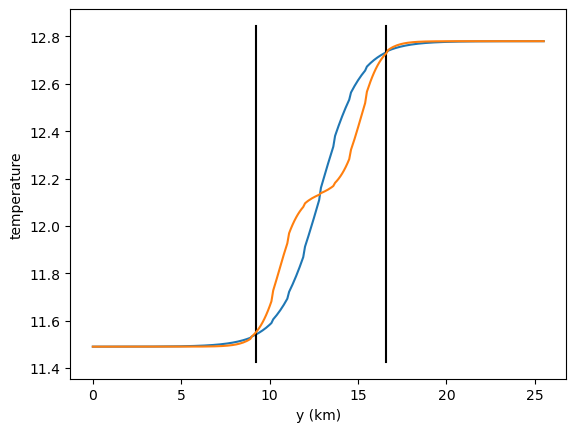

In [19]:
y = np.arange(0,n,1)
A = ((T_N[0]-T_S[0]))*((np.tanh(((y-(y_F+(n/2)))/25))+1)/2)+T_S[0]

B1 = ((T_N[0]-T_S[0]))/2*((np.tanh(((y-(y_F+(1.2*n/3)))/12.5))+1)/2)+T_S[0]
B2 = ((T_N[0]-T_S[0]))/2*((np.tanh(((y-(y_F+(3*n/5)))/12.5))+1)/2)

C1 = ((T_N[0]-T_S[0]))/3*((np.tanh(((y-(y_F+(3.6*n/10)))/7))+1)/2)+T_S[0]
C2 = ((T_N[0]-T_S[0]))/3*((np.tanh(((y-(y_F+(n/2)))/7))+1)/2)
C3 = ((T_N[0]-T_S[0]))/3*((np.tanh(((y-(y_F+(6.3*n/10)))/7))+1)/2)

D1 = ((T_N[0]-T_S[0]))/4*((np.tanh(((y-(y_F+(5.2*n/15)))/3))+1)/2)+T_S[0]
D2 = ((T_N[0]-T_S[0]))/4*((np.tanh(((y-(y_F+(6.7*n/15)))/3))+1)/2)
D3 = ((T_N[0]-T_S[0]))/4*((np.tanh(((y-(y_F+(8.3*n/15)))/3))+1)/2)
D4 = ((T_N[0]-T_S[0]))/4*((np.tanh(((y-(y_F+(9.8*n/15)))/3))+1)/2)

plt.plot(y/10,A)
y1 = plt.ylim()
a1 = np.where(A-np.min(A) > 0.05)
a2 = np.where(A-np.max(A) > -0.05)
plt.plot([a1[0][0]/10,a1[0][0]/10],y1,color = 'k')
plt.plot([a2[0][0]/10,a2[0][0]/10],y1,color = 'k')

B = B1+B2
plt.plot(y/10,B)
b1 = np.where(B-np.min(B) > 0.05)
b2 = np.where(B-np.max(B) > -0.05)
#plt.plot([b1[0][0]/10,b1[0][0]/10],y1,color = 'k',linestyle = '--')
#plt.plot([b2[0][0]/10,b2[0][0]/10],y1,color = 'k',linestyle = '--')

#C = C1+C2+C3
#plt.plot(y/10,C)
#c1 = np.where(C-np.min(C) > 0.05)
#c2 = np.where(C-np.max(C) > -0.05)
#plt.plot([c1[0][0]/10,c1[0][0]/10],y1,color = 'k',linestyle = ':')
#plt.plot([c2[0][0]/10,c2[0][0]/10],y1,color = 'k',linestyle = ':')

#D = D1+D2+D3+D4
#plt.plot(y/10,D)
#d1 = np.where(D-np.min(D) > 0.05)
#d2 = np.where(D-np.max(D) > -0.05)
#plt.plot([d1[0][0]/10,d1[0][0]/10],y1,color = 'k',linestyle = '--')
#plt.plot([d2[0][0]/10,d2[0][0]/10],y1,color = 'k',linestyle = '--')

plt.xlabel('y (km)')
plt.ylabel('temperature')

In [19]:
T_surf = T_front[0,:,:]
ML = T_surf*np.ones((22,n,n)) #og 22

fullT = np.concatenate((ML, T_front),axis=0)
T_3000m = fullT[0:nr,:,:]

# T_3000m.astype('>f4').tofile('temperature_w_meanderingfront.bin')

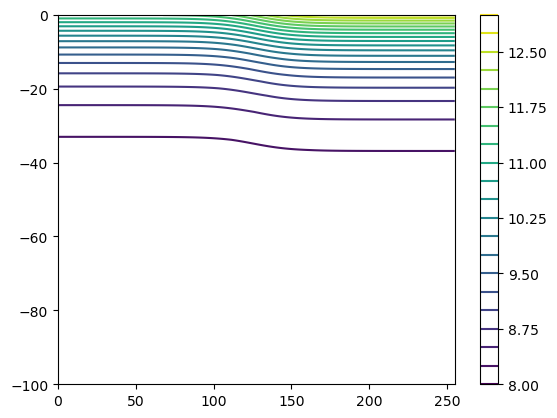

In [20]:
plt.contour(np.arange(0,n,1),Z,T_front[:,:,128],levels=20)
#plt.clim([8.5,11.5])
plt.ylim(-100,0)
plt.colorbar()
#plt.gca().invert_yaxis()

In [21]:
ML.shape

(22, 256, 256)

In [22]:
# T_surf = T_front[0,:,:]
# ML = T_surf*np.ones((22,n,n)) #og 22

# fullT = np.concatenate((ML, T_front),axis=0)
# T_3000m = fullT[0:nr,:,:]
# #
# T_3000m.astype('>f4').tofile('temperature_w_meanderingfront.bin')

## edit ML

In [23]:
T_surf = T_3000m[27,:,:]
ML = T_surf*np.ones((27,n,n)) #og 22

fullT = np.concatenate((ML, T_3000m[27:,:,:]),axis=0)
T_3000m = fullT[0:nr,:,:]

for i in np.arange(1,6):
    T_3000m[-1*i,:,:] = Tmin_int
T_3000m[-5,:,:] = (T_3000m[-4,:,:]+T_3000m[-6,:,:])*0.5
#
T_3000m.astype('>f4').tofile('temperature_w_stepfrontA.bin')

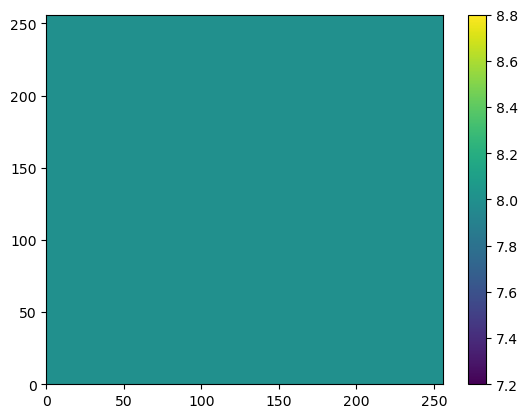

In [24]:
plt.pcolor(T_3000m[-4,:,:])
plt.colorbar()

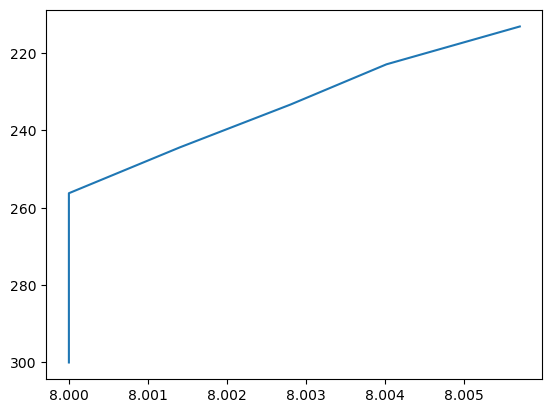

In [25]:
plt.plot(T_3000m[-8:,1,1],-Z[-8:])
plt.gca().invert_yaxis()

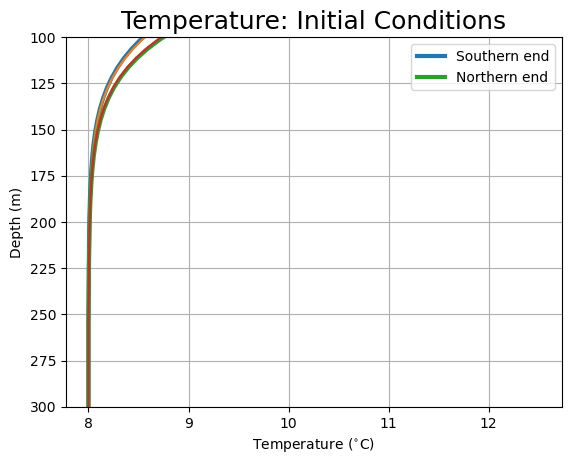

In [26]:
plt.plot(T_3000m[:,1,1], -Z, linewidth=3, label='Southern end')
plt.plot(T_3000m[:,100,1], -Z)
#plt.plot(T_3D[:,1,0],-Z)
plt.plot(T_3000m[:,-1,1], -Z, linewidth=3, label='Northern end')
plt.plot(T_3000m[:,-100,1], -Z)
#plt.plot(T_3000m[:,100,1], -Z, linewidth=3, label='mid')
#plt.plot(T_3D[:,20,1], pres)
plt.legend()
plt.grid()
plt.ylim(100,300)
plt.xlabel('Temperature ($^{\circ}$C)')
plt.ylabel('Depth (m)')
plt.title('Temperature: Initial Conditions', fontsize=18);
plt.gca().invert_yaxis()

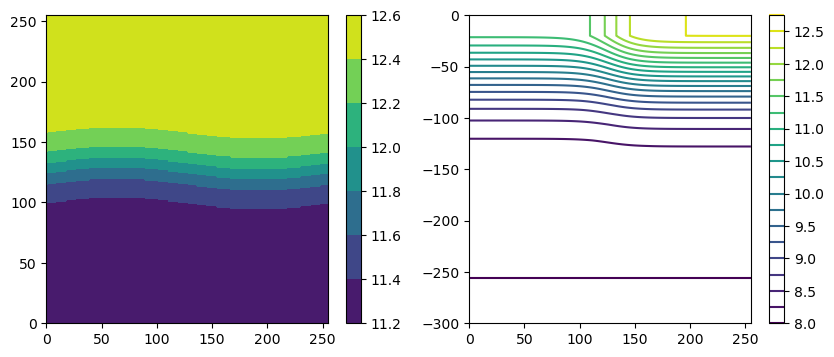

In [27]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.contourf(T_3000m[0,:,:])
#plt.clim([8.5,11.5])
plt.colorbar()

plt.subplot(122)
plt.contour(np.arange(0,n,1),Z,T_3000m[:,:,int(n/2)],levels=20)
plt.ylim(-300,0)
#plt.clim([8.5,11.5])
plt.colorbar()


## hyperbolic tangent

# Mask

In [92]:
rbcs_mask = np.zeros([nr, ny, nx])
rbcs_mask[1:,-10:,:] = 0.0
rbcs_mask[1:,-20:-10,:] = 0.0
rbcs_mask.astype('>f4').tofile('T_relax_mask.bin')

In [93]:
rbcs_mask.shape

(76, 256, 256)

# 3D Salinity

In [94]:
Smax = 35
Smin = 35
Smin_int = 35

S_surf = np.tile(np.linspace(Smin, Smax, n), (n,1)).T
#S_surf.astype('>f4').tofile('sss_relax.bin')

zscale = np.ones(len(T_3000m[:,-1,1]),)
zscale = np.reshape(zscale[0:nr], [nr,1,1])

#S_surf = sss_relax  
S_3D = np.reshape(S_surf - Smin_int, [1,ny,nx]) * zscale + Smin_int

In [95]:
ML = S_surf*np.ones((22,n,n))

In [96]:
fullS = np.concatenate((ML, S_3D),axis=0)
S_3000m = fullS[0:nr,:,:]

S_3000m.astype('>f4').tofile('salinity.bin')

In [97]:
S_3000m.shape

(76, 256, 256)

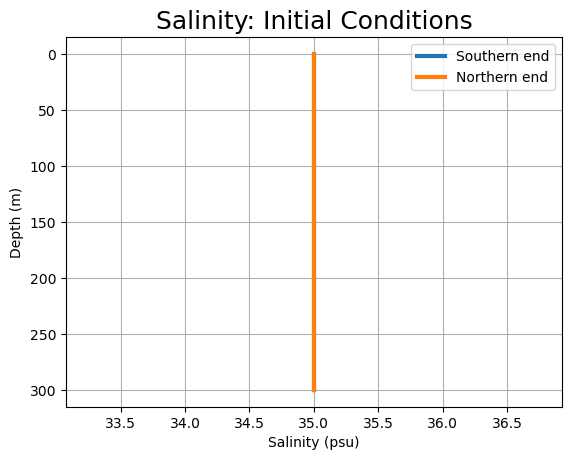

In [98]:
plt.plot(S_3000m[:,1,1], -Z, linewidth=3, label='Southern end')
plt.plot(S_3000m[:,-1,1], -Z, linewidth=3, label='Northern end')
#plt.plot(T_3D[:,20,1], pres)
plt.legend()
plt.grid()
plt.xlabel('Salinity (psu)')
plt.ylabel('Depth (m)')
plt.title('Salinity: Initial Conditions', fontsize=18);
plt.gca().invert_yaxis()

# Density and N2

In [20]:
sigma0_Ntest = gsw.sigma0(S_3000m[:,-1,1],T_3000m[:,-1,1])
sigma0_Stest = gsw.sigma0(S_3000m[:,1,1],T_3000m[:,1,1])

N2_Ntest,p_mid = gsw.Nsquared(S_3000m[:,-1,1],T_3000m[:,-1,1],Z)
N2_Stest,p_mid = gsw.Nsquared(S_3000m[:,1,1],T_3000m[:,1,1],Z)

NameError: name 'S_3000m' is not defined

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(141)
plt.plot(sigma0_Ntest,-Z,linestyle='-',c='b',label='model')
#plt.plot(np.mean(ds_kerg_SF_up.sigma0,axis=0),ds_kerg_SF_up.pressure,linestyle='-',c='m',label='SF, upstream')

#plt.plot(np.mean(ds_kerg_NF_down.sigma0,axis=0),ds_kerg_NF_down.pressure,linestyle='-',c='g',label='NF, downstream')
plt.xlabel('sigma_0',fontsize=15)
#plt.ylim(0,1000)
#plt.xlim(33.8,35)
plt.legend(loc='lower left')
plt.tick_params(top=False, bottom=True, left=True, right=False,
                labelleft=True, labelbottom=True, labelsize=12)
#plt.ylabel('Depth')
plt.gca().invert_yaxis()
plt.title('Northern boundary')

plt.subplot(142)
plt.plot(sigma0_Stest,-Z,linestyle='-',c='b',label='model')
#plt.plot(np.mean(ds_kerg_SF_up.sigma0,axis=0),ds_kerg_SF_up.pressure,linestyle='-',c='m',label='SF, upstream')

#plt.plot(np.mean(ds_kerg_NF_down.sigma0,axis=0),ds_kerg_NF_down.pressure,linestyle='-',c='g',label='NF, downstream')
plt.xlabel('sigma_0',fontsize=15)
#plt.ylim(0,1000)
#plt.xlim(33.8,35)
plt.legend(loc='lower left')
plt.tick_params(top=False, bottom=True, left=True, right=False,
                labelleft=False, labelbottom=True, labelsize=12)
#plt.ylabel('Depth')
plt.gca().invert_yaxis()
plt.title('Southern boundary')

plt.subplot(143)
plt.plot(sigma0_Stest,-Z,linestyle='-',c='b',label='model, S boundary')
plt.plot(sigma0_Ntest,-Z,linestyle='-',c='orange',label='model, N boundary')
#plt.plot(np.mean(ds_kerg_SF_up.sigma0,axis=0),ds_kerg_SF_up.pressure,linestyle='-',c='m',label='SF, upstream')

#plt.plot(np.mean(ds_kerg_NF_down.sigma0,axis=0),ds_kerg_NF_down.pressure,linestyle='-',c='g',label='NF, downstream')
plt.xlabel('sigma_0',fontsize=15)
#plt.ylim(0,1000)
#plt.xlim(33.8,35)
plt.legend(loc='lower left')
plt.tick_params(top=False, bottom=True, left=True, right=False,
                labelleft=False, labelbottom=True, labelsize=12)
#plt.ylabel('Depth')
plt.gca().invert_yaxis()

plt.subplot(144)
plt.plot(-N2_Stest,-p_mid,linestyle='-',c='b',label='model, S boundary')
plt.plot(-N2_Ntest,-p_mid,linestyle='-',c='orange',label='model, N boundary')
#plt.plot(np.mean(ds_kerg_SF_up.sigma0,axis=0),ds_kerg_SF_up.pressure,linestyle='-',c='m',label='SF, upstream')

#plt.plot(np.mean(ds_kerg_NF_down.sigma0,axis=0),ds_kerg_NF_down.pressure,linestyle='-',c='g',label='NF, downstream')
plt.xlabel('N^2',fontsize=15)
#plt.ylim(0,1000)
#plt.xlim(33.8,35)
plt.legend(loc='lower left')
plt.tick_params(top=False, bottom=True, left=True, right=False,
                labelleft=False, labelbottom=True, labelsize=12)
#plt.ylabel('Depth')
plt.gca().invert_yaxis()


In [ ]:
plt.figure(figsize=(8,6))
plt.subplot(121)
plt.plot(sigma0_Stest,-Z,linestyle='-',c='b',label='model, S boundary')
plt.plot(sigma0_Ntest,-Z,linestyle='-',c='orange',label='model, N boundary')
#plt.plot(np.mean(ds_kerg_SF_up.sigma0,axis=0),ds_kerg_SF_up.pressure,linestyle='-',c='m',label='SF, upstream')

#plt.plot(np.mean(ds_kerg_NF_down.sigma0,axis=0),ds_kerg_NF_down.pressure,linestyle='-',c='g',label='NF, downstream')
plt.xlabel('$\sigma_0$',fontsize=15)
#plt.ylim(0,1000)
#plt.xlim(33.8,35)
plt.legend(loc='lower left')
plt.tick_params(top=False, bottom=True, left=True, right=False,
                labelleft=True, labelbottom=True, labelsize=12)
plt.ylabel('Depth',fontsize=15)
plt.gca().invert_yaxis()

plt.subplot(122)
plt.plot(-N2_Stest,-p_mid,linestyle='-',c='b',label='model, S boundary')
plt.plot(-N2_Ntest,-p_mid,linestyle='-',c='orange',label='model, N boundary')
#plt.plot(np.mean(ds_kerg_SF_up.sigma0,axis=0),ds_kerg_SF_up.pressure,linestyle='-',c='m',label='SF, upstream')

#plt.plot(np.mean(ds_kerg_NF_down.sigma0,axis=0),ds_kerg_NF_down.pressure,linestyle='-',c='g',label='NF, downstream')
plt.xlabel('$N^2$',fontsize=15)
#plt.ylim(0,1000)
#plt.xlim(33.8,35)
plt.legend(loc='lower left')
plt.tick_params(top=False, bottom=True, left=True, right=False,
                labelleft=False, labelbottom=True, labelsize=12)
#plt.ylabel('Depth')
plt.gca().invert_yaxis()